<a href="https://colab.research.google.com/github/HoomanKhosravi/ImageSegmentation_Human_PyTourch_Unet/blob/main/ImageSegmentation_Human_PyTourch_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

#Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

#Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

#Setup Configurations

In [5]:
TRAIN_CSV = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = 'cuda'

EPOCHS = 25
LEARNING_RATE = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'



In [6]:
df = pd.read_csv(TRAIN_CSV)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[1]
mask_dir = row.masks
image_dir = row.images

image = cv2.imread(image_dir)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_dir, cv2.IMREAD_GRAYSCALE)/ 255.0 

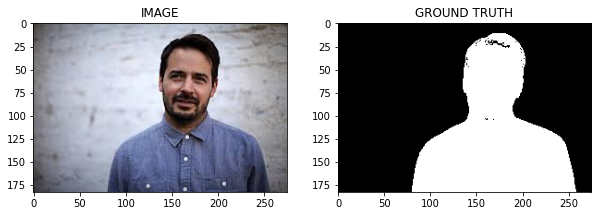

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 32)


#Augmentation

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as alb

In [11]:
def get_train_augs():
  return alb.Compose([
    alb.Resize(IMAGE_SIZE, IMAGE_SIZE),
    alb.HorizontalFlip(p = 0.5),
    alb.VerticalFlip(p = 0.5)
  ])
def get_valid_augs():
  return alb.Compose([
    alb.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])



#Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    mask_dir = row.masks
    image_dir = row.images

    image = cv2.imread(image_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_dir, cv2.IMREAD_GRAYSCALE) 
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']
    
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image)/ 255.0
    mask = torch.round( torch.Tensor(mask)/255.0 )

    return image, mask




In [14]:
train_set = SegmentationDataset( train_df, get_train_augs()) 
valid_set = SegmentationDataset( valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(train_set)}")
print(f"Size of Validset : {len(valid_set)}")

Size of Trainset : 232
Size of Validset : 58


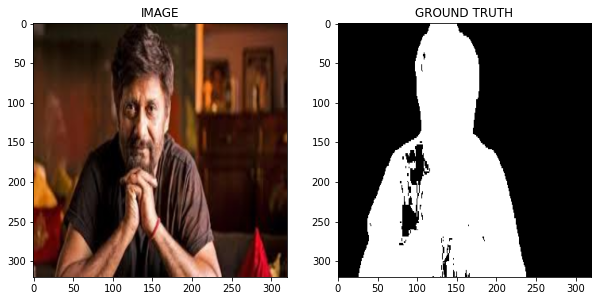

In [16]:
idx = 1
image, mask = train_set[idx]

helper.show_image(image, mask)

#Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle= True)
validloader = DataLoader(valid_set, batch_size=BATCH_SIZE)


In [19]:
print(f"total # of batches in trainloader : {len(trainloader)}")
print(f"total # of batches in validloader : {len(validloader)}")

total # of batches in trainloader : 15
total # of batches in validloader : 4


#Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [20]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [21]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [22]:
model = SegmentationModel();
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

#Create Train and Validation Function 

In [23]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logtis, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()

  return total_loss / len(data_loader)
  

In [24]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      
      logtis, loss = model(images, masks)
      
      
      
      total_loss += loss.item()

  return total_loss / len(data_loader)

#Train Model

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [26]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  
  train_loss = train_fn(trainloader ,model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Best Model Saved!')
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Best Model Saved!
Epoch : 1 Train Loss : 0.7679697553316752 Valid_loss : 0.9058920592069626


100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Best Model Saved!
Epoch : 2 Train Loss : 0.39166913827260336 Valid_loss : 0.63668592274189


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Best Model Saved!
Epoch : 3 Train Loss : 0.28174181779225665 Valid_loss : 0.35749174654483795


100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Epoch : 4 Train Loss : 0.3149893561999003 Valid_loss : 0.4878506064414978


100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Epoch : 5 Train Loss : 0.2514794598023097 Valid_loss : 0.3609659969806671


100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Best Model Saved!
Epoch : 6 Train Loss : 0.23394425213336945 Valid_loss : 0.28040986508131027


100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Epoch : 7 Train Loss : 0.1804417848587036 Valid_loss : 0.3063299059867859


100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Epoch : 8 Train Loss : 0.17019808441400527 Valid_loss : 0.2878343425691128


100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Epoch : 9 Train Loss : 0.15468791723251343 Valid_loss : 0.28070344030857086


100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Epoch : 10 Train Loss : 0.15195054213205975 Valid_loss : 0.28680281341075897


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Epoch : 11 Train Loss : 0.1456695814927419 Valid_loss : 0.30955081433057785


100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Epoch : 12 Train Loss : 0.13794779827197393 Valid_loss : 0.29465410113334656


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Epoch : 13 Train Loss : 0.12208722283442815 Valid_loss : 0.2872443050146103


100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Epoch : 14 Train Loss : 0.17777066280444462 Valid_loss : 0.36358199268579483


100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Epoch : 15 Train Loss : 0.1736040582259496 Valid_loss : 0.2852013632655144


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Epoch : 16 Train Loss : 0.1442156950632731 Valid_loss : 0.2838350422680378


100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Best Model Saved!
Epoch : 17 Train Loss : 0.12360563625892003 Valid_loss : 0.2611977085471153


100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Epoch : 18 Train Loss : 0.10093625982602437 Valid_loss : 0.26265043765306473


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Epoch : 19 Train Loss : 0.10403772691885631 Valid_loss : 0.2708696685731411


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epoch : 20 Train Loss : 0.11924885263045629 Valid_loss : 0.3476734980940819


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Epoch : 21 Train Loss : 0.136250705520312 Valid_loss : 0.32887788116931915


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Epoch : 22 Train Loss : 0.12974193394184114 Valid_loss : 0.40905380994081497


100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Epoch : 23 Train Loss : 0.1271800364057223 Valid_loss : 0.2910674065351486


100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Epoch : 24 Train Loss : 0.11830747077862422 Valid_loss : 0.36780963838100433


100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch : 25 Train Loss : 0.1181529904405276 Valid_loss : 0.3424338400363922


#Inference

In [37]:
image = cv2.imread('/content/20191110_134938.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, [IMAGE_SIZE, IMAGE_SIZE], interpolation = cv2.INTER_AREA)

image = np.transpose(image, (2,0,1)).astype(np.float32)
image = torch.Tensor(image)/ 255.0


In [38]:
idx = 1

model.load_state_dict(torch.load('/content/best_model.pt'))

#image, mask = valid_set[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*0.1

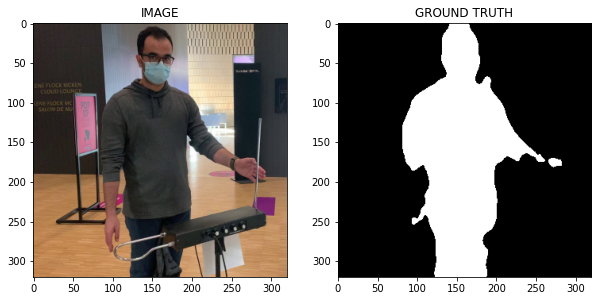

In [39]:
helper.show_image(image, pred_mask.detach().cpu().squeeze(0))